In [15]:
import os

import numpy as np
from numpy import random
import pandas as pd
import glob
import math
import tqdm

import torch
import matplotlib.pyplot as plt

from diffusion.data_util import get_ckpt_path, show_out_images, get_logger_path, train_plot, img_plot
from diffusion.script_util import ModelType, VarType
from diffusion.lightning_modules import DiffusionWithModel, MNISTDataModule
from diffusion.vgg5 import VGG5
from diffusion.vae import SimpleVAE
from diffusion.evaluations import CounterfactEvaluator

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


work_dir = r'C:\Users\niels\local_data\bachelor'
models_dir = os.path.join(work_dir, 'models')
helper_dir = os.path.join(work_dir, 'eval_models')
data_dir = os.path.join(work_dir, 'datasets')

get_model_paths = lambda dir: glob.glob(os.path.join(models_dir, dir, '*.ckpt'), recursive=True)

vae = SimpleVAE.load_from_checkpoint(os.path.join(helper_dir, 'vae.ckpt')).eval().to(device)
classifier = VGG5.load_from_checkpoint(os.path.join(helper_dir, 'classifier.ckpt')).eval().to(device)

data_module = MNISTDataModule(
    data_dir=data_dir
)
data_module.prepare_data()
data_module.setup('test')

In [17]:
# sched_dir = r'cond-scheduled-var-42\lightning_logs\version_0\checkpoints'
# sched_path = get_model_paths(sched_dir)[4]

# pred_dir = r'cond-predicted-var-42\lightning_logs\version_0\checkpoints'
# pred_path = get_model_paths(pred_dir)[4]

uncond_dir = r'uncond-learned-42\lightning_logs\version_0\checkpoints'
uncond_path = get_model_paths(uncond_dir)[3]
get_model_paths(uncond_dir)

plot_path = './plots/'

In [18]:
combined_model = DiffusionWithModel.load_from_checkpoint(uncond_path).to(device)
unet_model, diffusion = combined_model.extract_models()

c:\Users\niels\anaconda3\envs\bachelor\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.4, which is newer than your current Lightning version: v1.9.3
  rank_zero_warn(


# quantitative

In [5]:
experiments = {
    9: [4]
}
batch_size = 16

data_module.batch_size = batch_size
evaluator = CounterfactEvaluator(
    data_module=data_module,
    combined_model=combined_model,
    vae=vae,
    classifier=classifier,
    experiments=experiments,
    batch_size=batch_size,
    save_results=False,
)

In [6]:
# pair_fid = evaluator.calculate_pair_wise_FVAED()
# fig, ax = plt.subplots(figsize=(7.5, 7.5))
# show_pair_fid = pair_fid
# ax.matshow(show_pair_fid, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(show_pair_fid.shape[0]):
#     for j in range(show_pair_fid.shape[1]):
#         text = show_pair_fid[i, j]
#         text = f'{text:.1f}' if text and j>i else ' '
#         ax.text(x=j, y=i, s=text, va='center', ha='center', size='large')
# plt.title('Label distribution distance', fontsize=18)

# plt.savefig(plot_path + 'pairwise_distance', bbox_inches='tight')


In [7]:
# tau = 1#10
# lambda_p = 10
# lambda_c = 30
# vgg_block = 1#3
# n_reconstruct_samples=1

# evaluation_results = evaluator.do_all_tests(
#     tau=tau,
#     lambda_p=lambda_p,
#     lambda_c=lambda_c,
#     vgg_block=vgg_block,
#     n_reconstruct_samples=n_reconstruct_samples
# )
# evaluation_results

# qualitative

In [5]:
batch_size = 64

data_module.batch_size = batch_size
data_module.prepare_data()
data_module.label_subset = None
data_module.setup('fit')
dataloader = data_module.val_dataloader()
val_dataset = iter(dataloader)
i = -1

In [6]:
for _ in range(6):
    i += 1
    next(val_dataset)

6


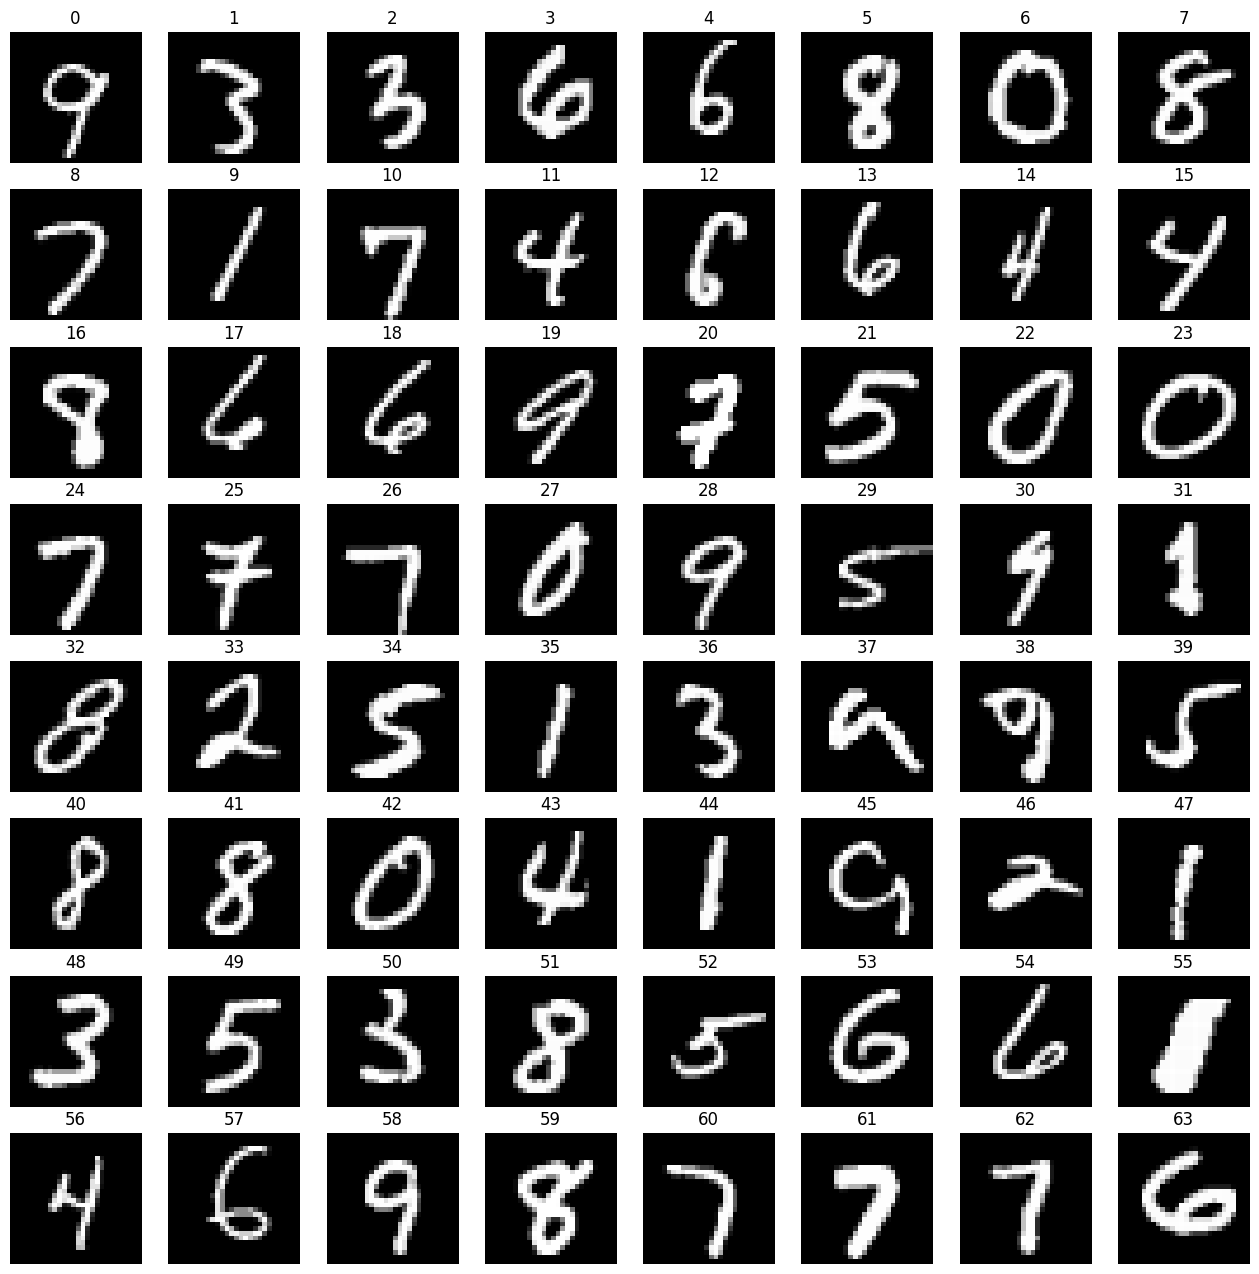

In [7]:
i += 1
print(i)
imgs, y = next(val_dataset)
idxs = torch.arange(batch_size, device=device)
fig = show_out_images(imgs, y=idxs, ax_kwargs=dict(cmap='gray'))
# plt.savefig(plot_path + 'mnist_data', bbox_inches='tight')
plt.show()

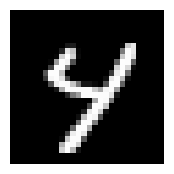

In [10]:
show_out_images(imgs[15][None, ...], ax_kwargs=dict(cmap='gray'))
plt.savefig(plot_path + 'mnist_example_image', bbox_inches='tight')
plt.show()

In [292]:
y_start = 4
batch_size = 16

data_module.batch_size = batch_size
data_module.label_subset = [y_start]
data_module.setup('fit')
partial_dataloader = data_module.val_dataloader()
batch = next(iter(partial_dataloader))
x, y = batch
x = x.to(device)

100%|██████████| 24/24 [01:07<00:00,  2.79s/it]


Fraction converted 0.44


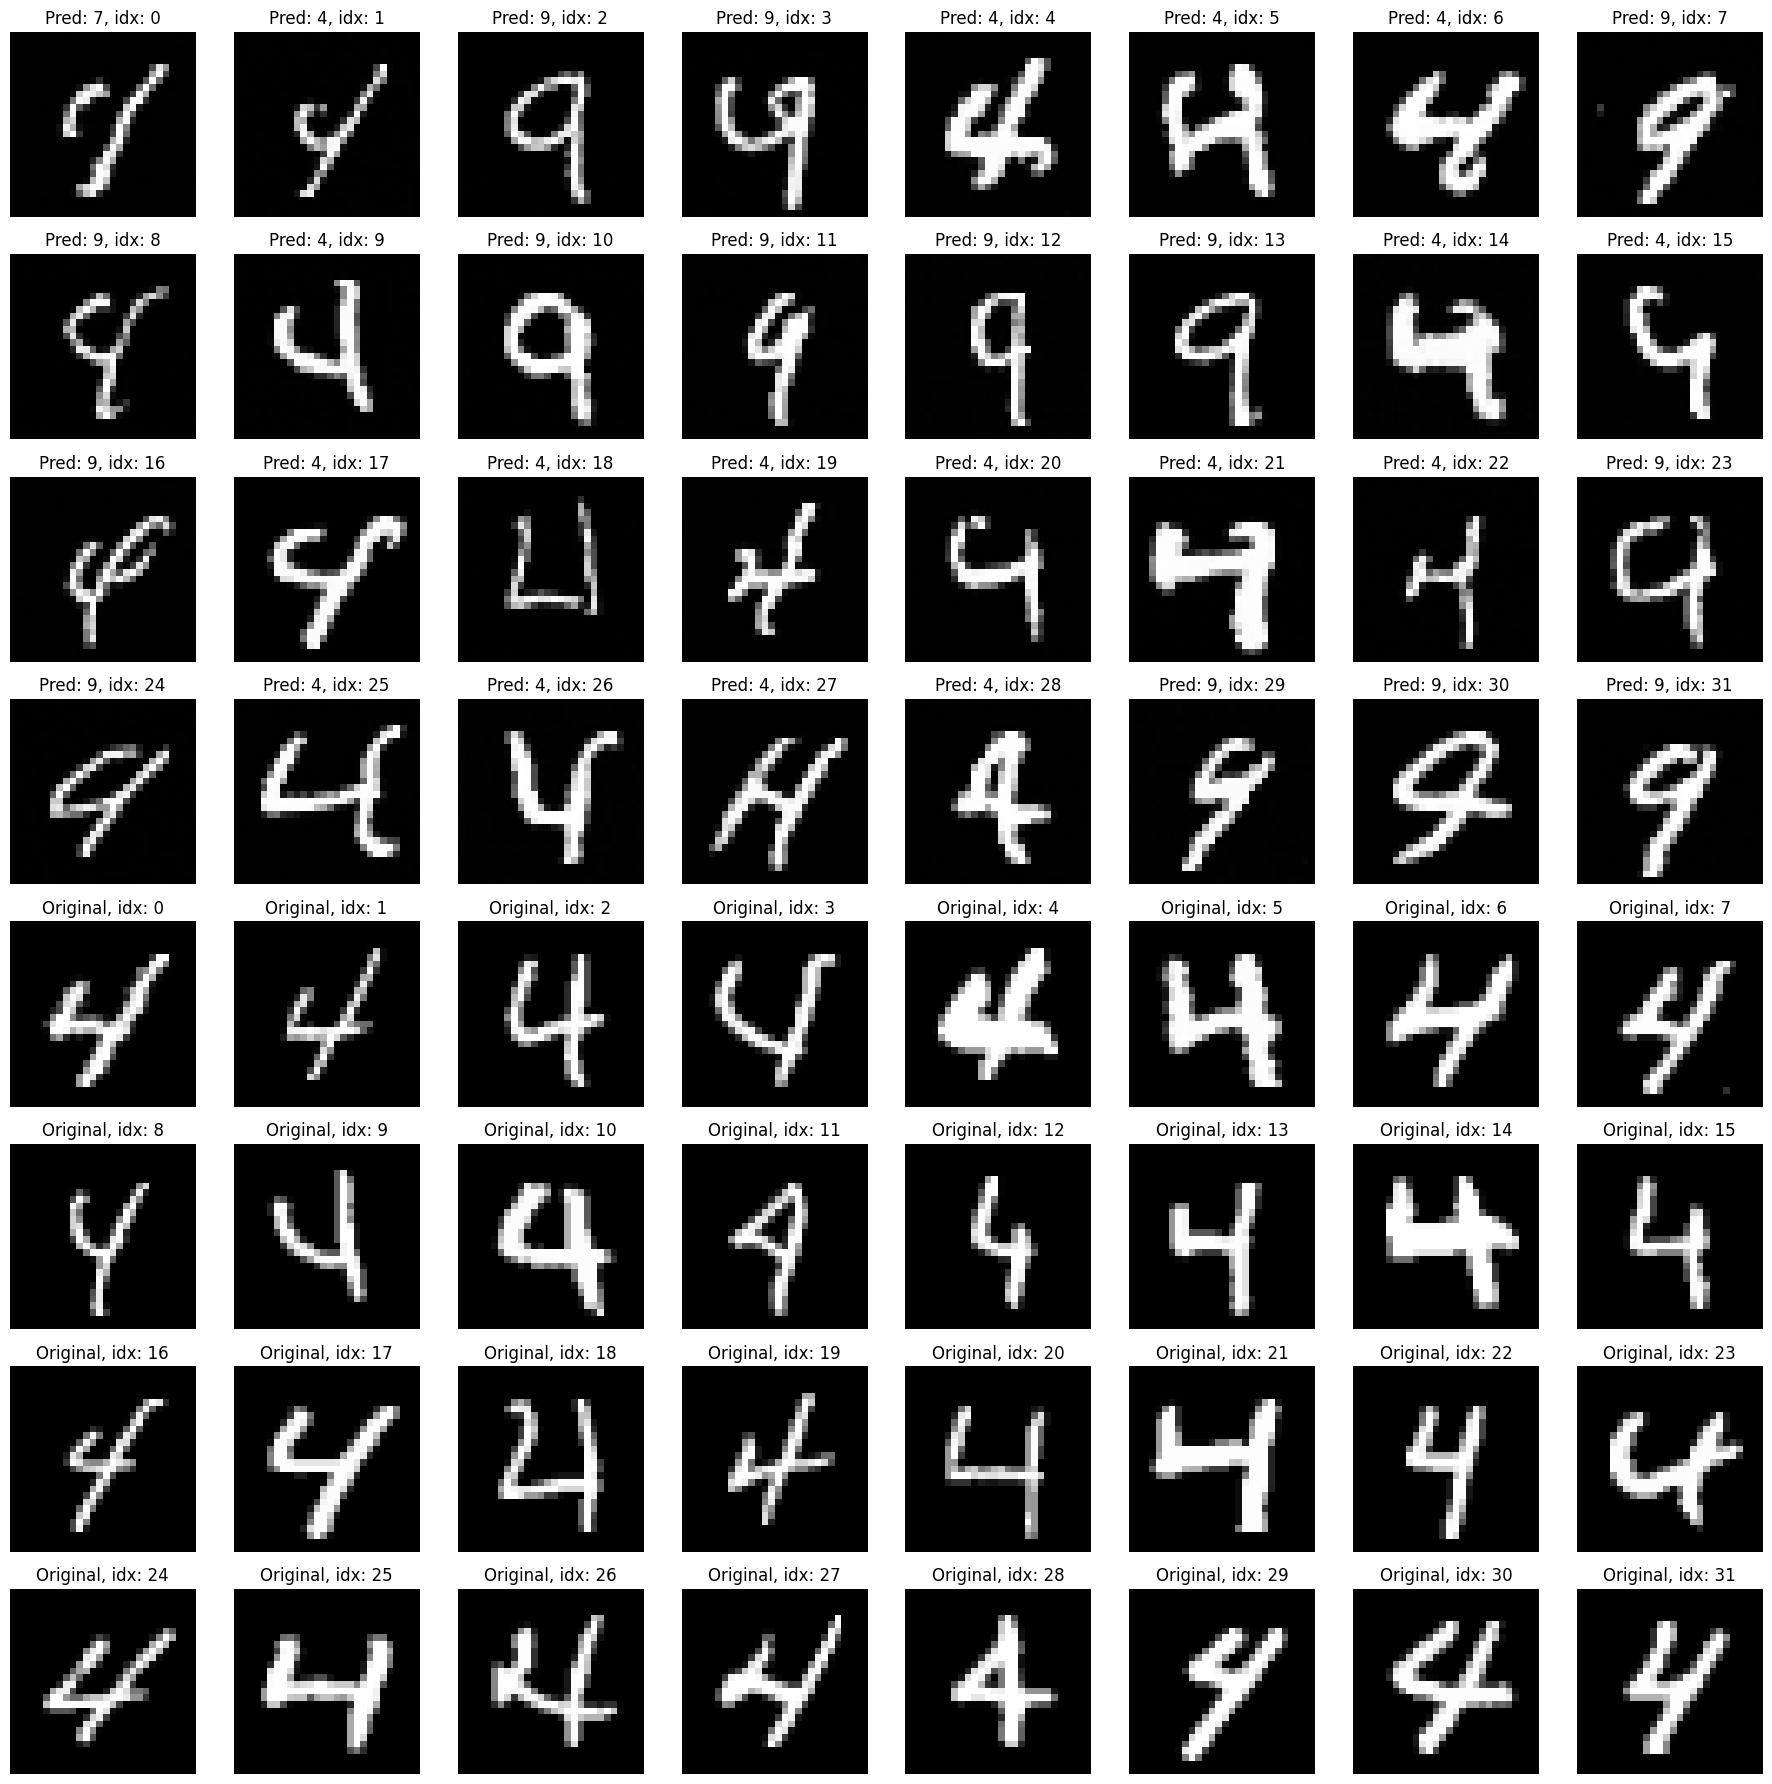

In [291]:
y_target = 9

defualt_hyper_params = dict(
    tau = 24,
    lambda_p = 1,
    lambda_c = 60,
    vgg_block = 2,
    n_reconstruct_samples = 1
)

counterfact = diffusion.guided_counterfactual(
    unet_model,
    classifier,
    x,
    y_target,
    **defualt_hyper_params
)
y_pred = classifier.predict(counterfact)

images = torch.cat([counterfact, x], dim=0)
titles = [f'Pred: {p}, idx: {idx}' for idx, p in enumerate(y_pred.cpu().numpy())] + [f'Original, idx: {idx}' for idx in range(batch_size)]

show_out_images(images, y=titles, figsize=(4*math.sqrt(batch_size),)*2, ax_kwargs=dict(cmap='gray'))
print(f'Fraction converted {(y_pred.cpu().numpy() == y_target).mean():.2f}')
plt.savefig(plot_path + 'counterfact_example', bbox_inches='tight')
plt.show()

100%|██████████| 4/4 [03:25<00:00, 51.32s/it]

n_reconstruct_samples


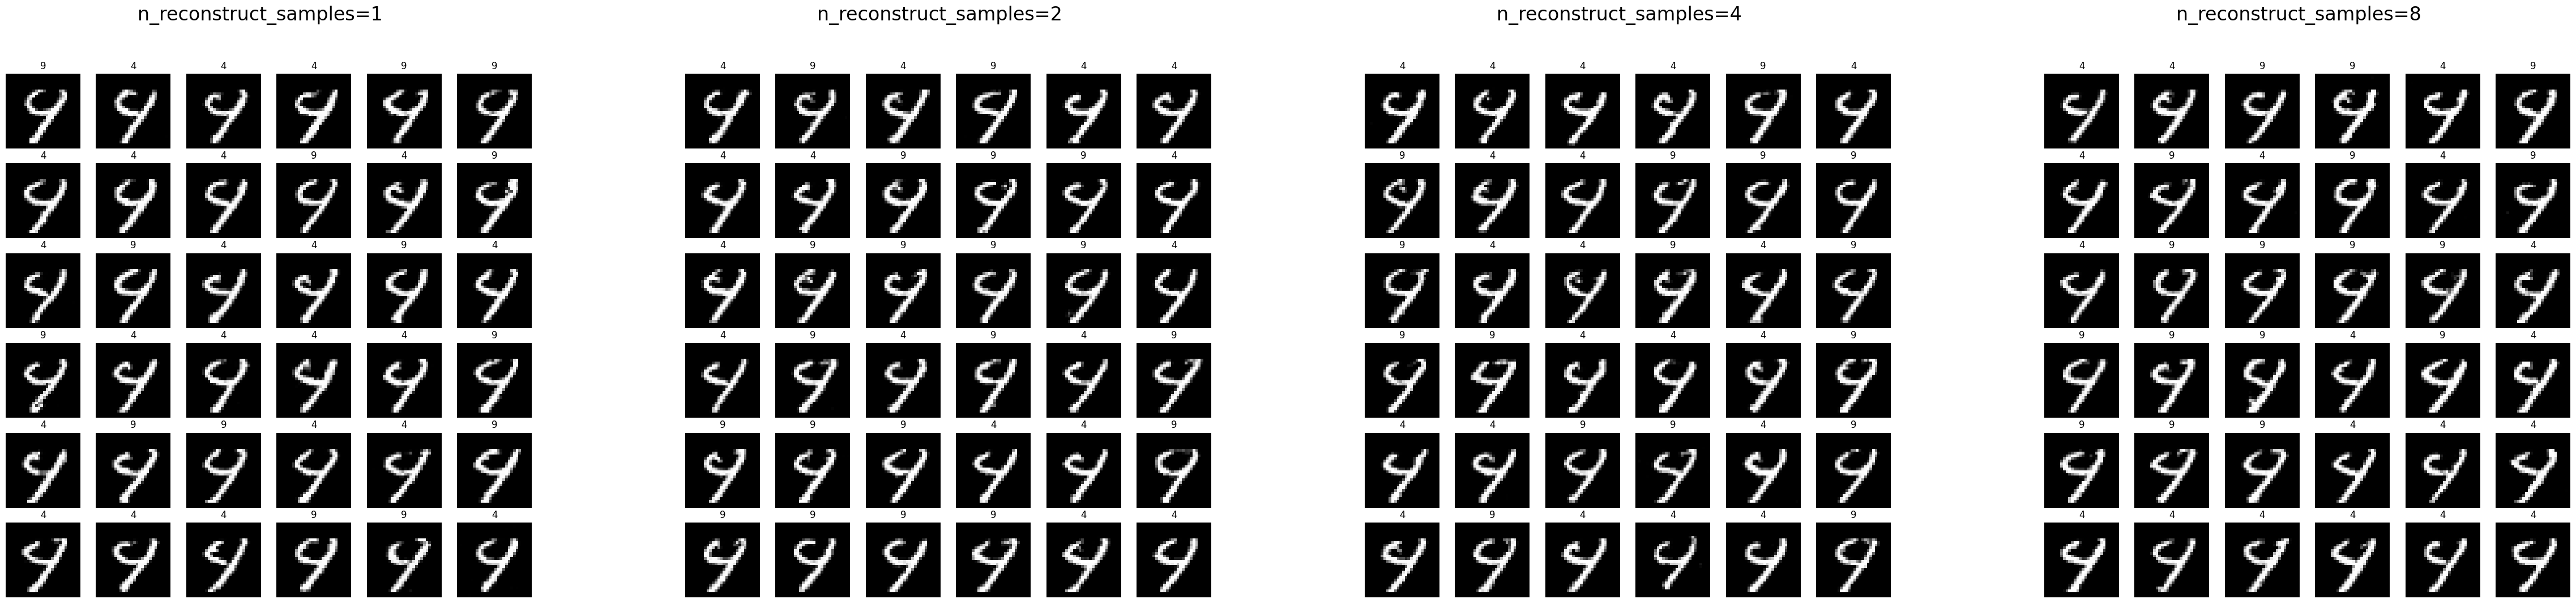

In [14]:
idx = 15 # which img to use
y_target = 9 # cf target
batch_size = 36 # num examples per hyper param

size = 2 # img side size
show_pbar = True


varying_hyper_params = dict(
    # tau = [10, 15, 20, 25, 30],
    # lambda_p = [0, 2, 4, 8, 16],
    # lambda_c = [80, 100, 120, 140],
    # vgg_block = [1, 2, 3, 4],
    n_reconstruct_samples = [1, 2, 4, 8],
)

# defualt_hyper_params = dict(
#     tau = 24, #25
#     lambda_p = 8,
#     lambda_c = 60,
#     vgg_block = 2,
#     n_reconstruct_samples = 1
# )

defualt_hyper_params_n_reconstruct = dict(
    tau = 10, #25
    lambda_p = 2,
    lambda_c = 160,
    vgg_block = 2,
    n_reconstruct_samples = 8
)


img_shape = (1, 1, 28, 28)
x_0 = torch.cat([imgs[idx].reshape(*img_shape) for _ in range(batch_size)])
for hp_key, hp_vals in varying_hyper_params.items():
    n_steps = len(hp_vals)
    multiplot_side = math.sqrt(batch_size)
    
    fig = plt.figure(figsize=(multiplot_side*size*n_steps, multiplot_side*size))
    fig.suptitle('Counterfact hyperparam', size=16)
    subfigs = fig.subfigures(1, n_steps)
    
    iterator = tqdm.tqdm(zip(subfigs, hp_vals), total=n_steps) if show_pbar else zip(subfigs, hp_vals)
    
    for subfig, hp_val in iterator:
        sample_hps = defualt_hyper_params_n_reconstruct | {hp_key: hp_val}
        subfig.suptitle(f'{hp_key}={hp_val}', size=24)
        
        counterfact = diffusion.guided_counterfactual(
            unet_model,
            classifier,
            x_0,
            y_target,
            show_pbar=False,
            **sample_hps
        ).clamp(0, 1)
        
        y_pred = classifier.predict(counterfact)
        show_out_images(counterfact, y=y_pred, fig=subfig, ax_kwargs=dict(cmap='gray'))
    print(hp_key, flush=True)
    plt.savefig(plot_path + f'counterfact_{hp_key}_multirun', bbox_inches='tight')
    plt.show()

100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


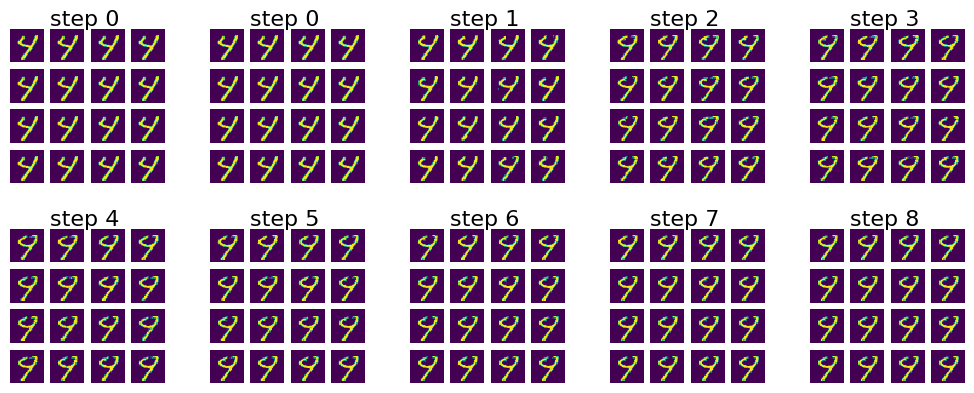

In [331]:
img_shape = (1, 1, 28, 28)

torch.manual_seed(0)

idx = 15 # which img to use
size = 2 # img side size
n_samples = 1 # 16 # num img
y_target = 9
num_intermidiate_steps = 10
show_preds = False
n_rows = 2

version = 'test'

defualt_hyper_params = dict(
    tau = 8, #25
    lambda_p = 2,
    lambda_c = 20,
    vgg_block = 2,
    n_reconstruct_samples = 16
)

show_steps = np.linspace(0, defualt_hyper_params['tau'], num_intermidiate_steps, endpoint=True, dtype=int)

assert max(show_steps) <= defualt_hyper_params['tau'], f"Cannot show step {max(show_steps)} when {defualt_hyper_params['tau']=}"

n_steps = len(show_steps)
x_0 = imgs[idx].reshape(*img_shape)
x_t_batch = torch.cat([x_0.clone() for _ in range(n_samples)])
multiplot_side = math.sqrt(n_samples)

fig = plt.figure(figsize=(multiplot_side*size*n_steps/n_rows, multiplot_side*size*n_rows))
fig.suptitle('Intermidiate steps', size=16)
subfigs = fig.subfigures(n_rows, math.ceil(n_steps/n_rows))

_, intermediate_reconstructs = diffusion.guided_counterfactual(
        unet_model,
        classifier,
        x_t_batch,
        y_target,
        return_intermediate=True,
        **defualt_hyper_params
)
intermediate_reconstructs = intermediate_reconstructs.clamp(0, 1)

for figure, step in zip(subfigs.flatten(), show_steps):
    figure.suptitle(f'step {step}', size=16)
    x_reconstruct = intermediate_reconstructs[step]
    y_pred = classifier.predict(x_reconstruct) if show_preds else None
    show_out_images(x_reconstruct, y=y_pred, fig=figure)

plt.savefig(plot_path + 'counterfact_intermidiate_'+version, bbox_inches='tight')
plt.show()

In [308]:
# for use in path plot
paths = [2, 7, 10]

In [6]:
batch_size = 64

data_module.batch_size = batch_size
data_module.label_subset = [4, 9]
data_module.setup('fit')
partial_dataloader = data_module.val_dataloader()


In [7]:
all_latent = list()
all_labels = list()
all_preds = list()
all_losses_4 = list()
all_losses_9 = list()

for batch in tqdm.tqdm(iter(partial_dataloader)):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    latent = vae.encode(x)
    pred = classifier.forward(x).softmax(dim=-1)
    loss_4 = torch.nn.functional.cross_entropy(pred, 4*torch.ones_like(y), reduction='none')
    loss_9 = torch.nn.functional.cross_entropy(pred, 9*torch.ones_like(y), reduction='none')
    
    all_losses_4.append(loss_4)
    all_losses_9.append(loss_9)
    all_preds.append(pred)
    all_latent.append(latent)
    all_labels.append(y)

all_losses_4 = torch.cat(all_losses_4, dim=0).detach().cpu().numpy()
all_losses_9 = torch.cat(all_losses_9, dim=0).detach().cpu().numpy()
all_preds = torch.cat(all_preds, dim=0).detach().cpu().numpy()
all_latent = torch.cat(all_latent, dim=0).detach().cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).detach().cpu().numpy()

100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


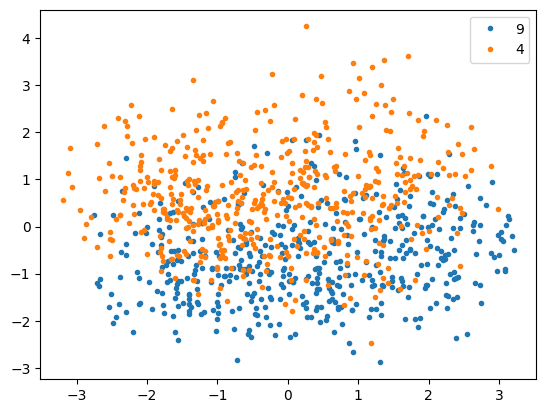

In [311]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(all_latent)

latent_pca = pca.transform(all_latent)
plt.plot(latent_pca[:, 0][all_labels==9], latent_pca[:, 1][all_labels==9], '.', label='9')
plt.plot(latent_pca[:, 0][all_labels==4], latent_pca[:, 1][all_labels==4], '.', label='4')
plt.legend()
plt.savefig(plot_path + 'latent_pca_raw', bbox_inches='tight')
plt.show()

In [312]:
# calculate mean and variance of the latent space by label
from scipy.stats import multivariate_normal

# function to get probability of label 4 given being either 4 or 9
def get_posterior(latent, start_label=4, target_label=9):
    mean_start = latent_pca[all_labels==start_label].mean(axis=0)
    cov_start = np.cov(latent_pca[all_labels==start_label].T)
    
    mean_target = latent_pca[all_labels==target_label].mean(axis=0)
    cov_target = np.cov(latent_pca[all_labels==target_label].T)
    
    start_prob = multivariate_normal.pdf(latent, mean=mean_start, cov=cov_start)
    target_prob = multivariate_normal.pdf(latent, mean=mean_target, cov=cov_target)
    
    posterior = target_prob/(start_prob+target_prob)
    return posterior

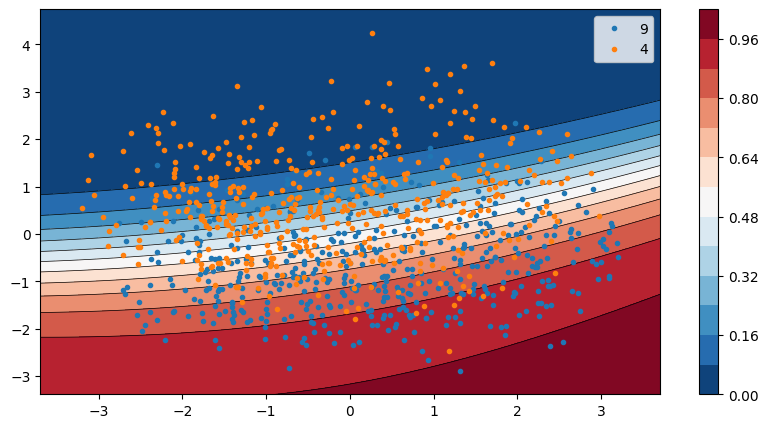

In [313]:
padding = .5
quality = (100, 100)

x_min, x_max = latent_pca[:, 0].min() - padding, latent_pca[:, 0].max() + padding
y_min, y_max = latent_pca[:, 1].min() - padding, latent_pca[:, 1].max() + padding

x1d = np.linspace(x_min, x_max, quality[0])
y1d = np.linspace(y_min, y_max, quality[1])

xs, ys = np.meshgrid(x1d, y1d)
out_shape = xs.shape

zs = get_posterior(np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1)], axis=1))
zs = zs.reshape(quality)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.contour(xs, ys, zs, levels=14, linewidths=0.5, colors='k')
cntr2 = ax.contourf(xs, ys, zs, levels=14, cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)

ax.plot(latent_pca[all_labels==9, 0], latent_pca[all_labels==9, 1], '.', label='9')
ax.plot(latent_pca[all_labels==4, 0], latent_pca[all_labels==4, 1], '.', label='4')
ax.legend()

plt.savefig(plot_path + 'latent_pca_contour', bbox_inches='tight')
_ = plt.show()

C:\Users\niels\AppData\Local\Temp\ipykernel_16368\3605464717.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 2*n_dots-1+offset)


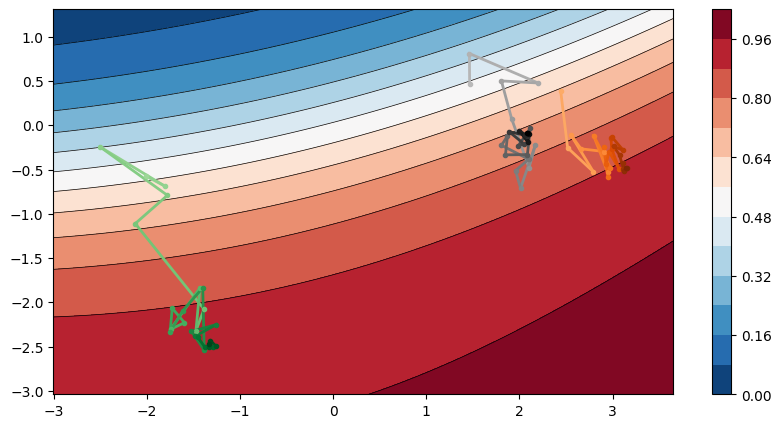

In [314]:
from matplotlib import cm

cmap_names = ['Greys', 'Greens', 'Oranges']
padding = .5


def plot_multicol_line(ax, x, y, cmap_name, offset=30, **kwargs):
    n_dots = len(x)
    cmap = cm.get_cmap(cmap_name, 2*n_dots-1+offset)
    
    # lines
    for start, end in zip(range(n_dots-1), range(1, n_dots)):
        ax.plot(x[start:end+1], y[start:end+1], '-', color=cmap(2*start+1+offset), **kwargs)
    
    # dots
    for i in range(n_dots):
        ax.plot(x[i], y[i], '.', color=cmap(i*2+offset), **kwargs)


manifold_paths = list()

for i in paths:
    manifold_path = intermediate_reconstructs[:, i]
    manifold_path = vae.encode(manifold_path)
    manifold_path = pca.transform(manifold_path.detach().cpu().numpy())
    manifold_paths.append(manifold_path)

quality = (100, 100)

points = np.concatenate(manifold_paths)
x_min, x_max = points[:, 0].min() - padding, points[:, 0].max() + padding
y_min, y_max = points[:, 1].min() - padding, points[:, 1].max() + padding

x1d = np.linspace(x_min, x_max, quality[0])
y1d = np.linspace(y_min, y_max, quality[1])

xs, ys = np.meshgrid(x1d, y1d)
out_shape = xs.shape

zs = get_posterior(np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1)], axis=1))
zs = zs.reshape(quality)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.contour(xs, ys, zs, levels=14, linewidths=0.5, colors='k')
cntr2 = ax.contourf(xs, ys, zs, levels=14, cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)

for p, c in zip(manifold_paths, cmap_names):
    plot_multicol_line(ax, p[:, 0], p[:, 1], c, linewidth=2)
    
plt.savefig(plot_path + 'latent_pca_contour_paths_'+version, bbox_inches='tight')
plt.show()

In [8]:
import umap

reducer = umap.UMAP(n_neighbors=50, negative_sample_rate=50)
reducer.fit(all_latent)
umap_projected = reducer.transform(all_latent)

c:\Users\niels\anaconda3\envs\bachelor\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\niels\anaconda3\envs\bachelor\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\niels\anaconda3\envs\bachelor\lib\site-packages\umap\distances.py:1086: Num

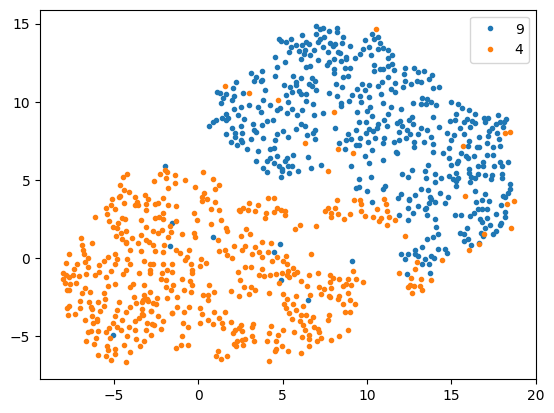

In [9]:
plt.plot(umap_projected[:, 0][all_labels==9], umap_projected[:, 1][all_labels==9], '.', label='9')
plt.plot(umap_projected[:, 0][all_labels==4], umap_projected[:, 1][all_labels==4], '.', label='4')
plt.legend()

plt.savefig(plot_path + 'latent_umap_raw', bbox_inches='tight')
plt.show()

In [10]:
from sklearn.neighbors import KernelDensity

def get_posterior_kde(latent, unlikely_cutoff=0.1, start_label=4, target_label=9):
    kde_start = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(umap_projected[all_labels==start_label])
    kde_target = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(umap_projected[all_labels==target_label])
        
    start_prob = np.exp(kde_start.score_samples(latent))
    target_prob = np.exp(kde_target.score_samples(latent))
    
    mask = (start_prob+target_prob) > unlikely_cutoff
    
    posterior = target_prob/(start_prob+target_prob)
    return np.where(mask, posterior, 0.5)

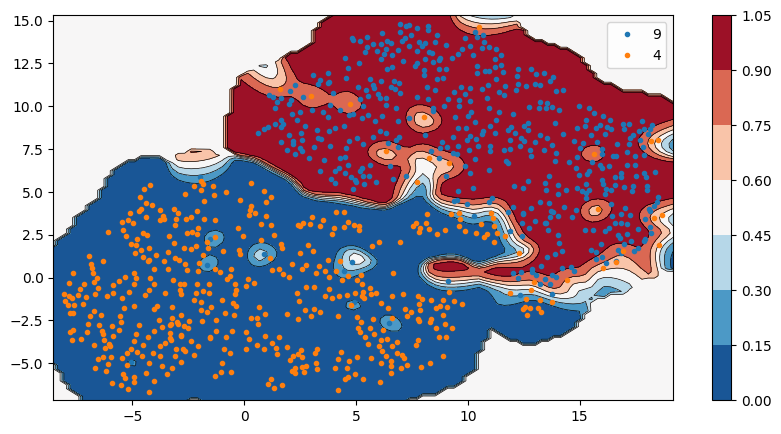

In [15]:
padding = .5
quality = (100, 100)

levels = 8

x_min, x_max = umap_projected[:, 0].min() - padding, umap_projected[:, 0].max() + padding
y_min, y_max = umap_projected[:, 1].min() - padding, umap_projected[:, 1].max() + padding

x1d = np.linspace(x_min, x_max, quality[0])
y1d = np.linspace(y_min, y_max, quality[1])

xs, ys = np.meshgrid(x1d, y1d)
out_shape = xs.shape

zs = get_posterior_kde(np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1)], axis=1), unlikely_cutoff=0.00001)
zs = zs.reshape(quality)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.contour(xs, ys, zs, levels=levels, linewidths=0.5, colors='k')
cntr2 = ax.contourf(xs, ys, zs, levels=levels, cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)

ax.plot(umap_projected[all_labels==9, 0], umap_projected[all_labels==9, 1], '.', label='9')
ax.plot(umap_projected[all_labels==4, 0], umap_projected[all_labels==4, 1], '.', label='4')
ax.legend()

plt.savefig(plot_path + 'latent_umap_contour', bbox_inches='tight')
_ = plt.show()

C:\Users\niels\AppData\Local\Temp\ipykernel_16368\3605464717.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 2*n_dots-1+offset)


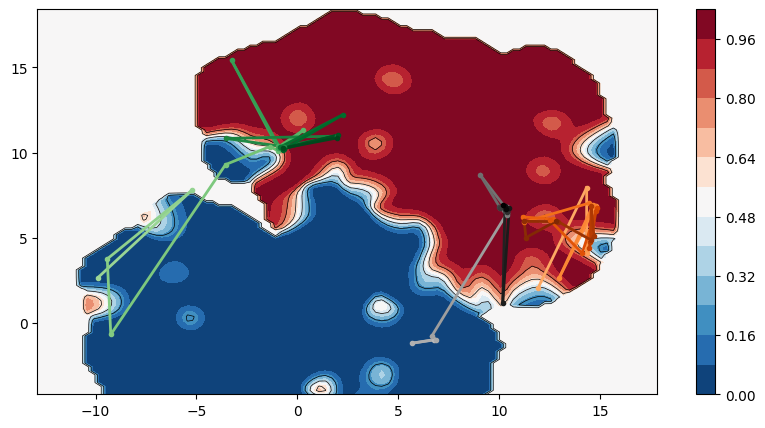

In [319]:
cmap_names = ['Greys', 'Greens', 'Oranges']
padding = 3

quality = (100, 100)

manifold_paths = list()

for i in paths:
    manifold_path = intermediate_reconstructs[:, i]
    manifold_path = vae.encode(manifold_path)
    manifold_path = reducer.transform(manifold_path.detach().cpu().numpy())
    manifold_paths.append(manifold_path)

points = np.concatenate(manifold_paths)
x_min, x_max = points[:, 0].min() - padding, points[:, 0].max() + padding
y_min, y_max = points[:, 1].min() - padding, points[:, 1].max() + padding

x1d = np.linspace(x_min, x_max, quality[0])
y1d = np.linspace(y_min, y_max, quality[1])

xs, ys = np.meshgrid(x1d, y1d)
out_shape = xs.shape

zs = get_posterior_kde(np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1)], axis=1), unlikely_cutoff=0.00001)
zs = zs.reshape(quality)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.contour(xs, ys, zs, levels=5, linewidths=0.5, colors='k')
cntr2 = ax.contourf(xs, ys, zs, levels=14, cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)

for p, c in zip(manifold_paths, cmap_names):
    plot_multicol_line(ax, p[:, 0], p[:, 1], c, linewidth=2)

plt.savefig(plot_path + 'latent_umap_contour_paths_'+version, bbox_inches='tight')
_ = plt.show()

# classifier misclassification CF

In [19]:
batch_size = 64

data_module.batch_size = batch_size
data_module.prepare_data()
data_module.label_subset = None
data_module.setup('fit')
dataloader = data_module.val_dataloader()

In [39]:
misclassified_x = list()
misclassified_y = list()
for batch in tqdm.tqdm(iter(dataloader)):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    preds = classifier.predict(x)
    keep = preds != y.to(device)
    misclassified_y.append(y[keep]) if keep.sum() > 0 else None
    misclassified_x.append(x[keep]) if keep.sum() > 0 else None

misclassified_x = torch.cat(misclassified_x)
misclassified_y = torch.cat(misclassified_y)

100%|██████████| 79/79 [00:06<00:00, 12.86it/s]


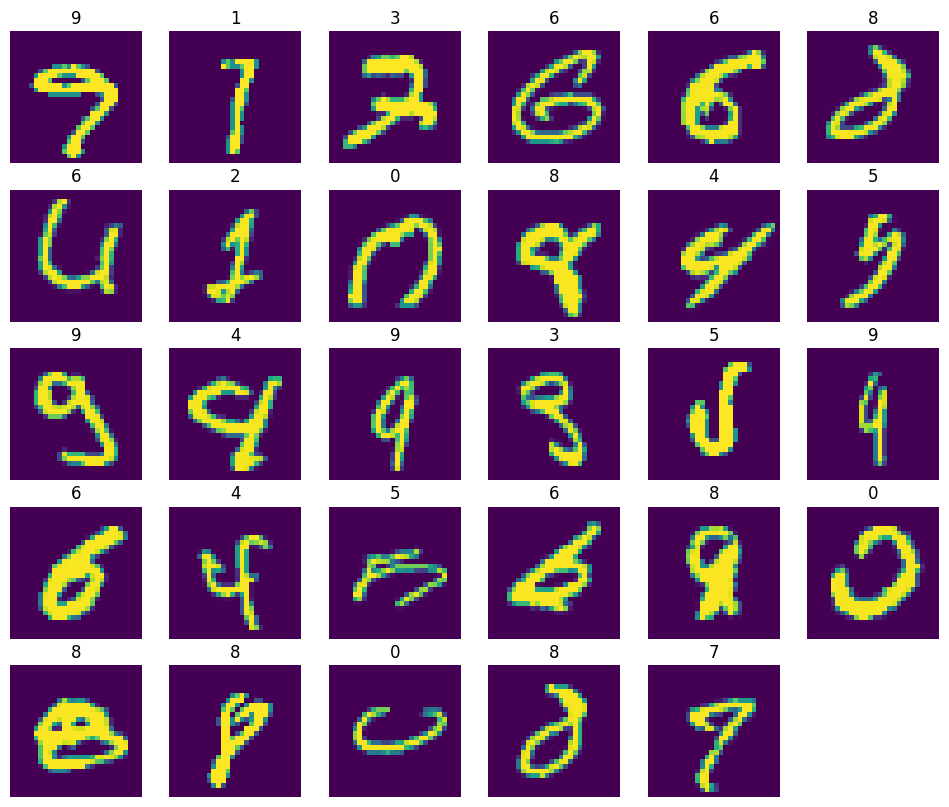

In [40]:
fig = show_out_images(misclassified_x, misclassified_y)
plt.show()

In [41]:
label = 9
misclassified_batch = misclassified_x[misclassified_y==label]

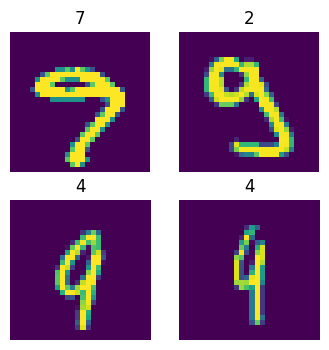

In [42]:
misclassified_pred = classifier.predict(misclassified_batch)
fig = show_out_images(misclassified_batch, misclassified_pred)
plt.show()

100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


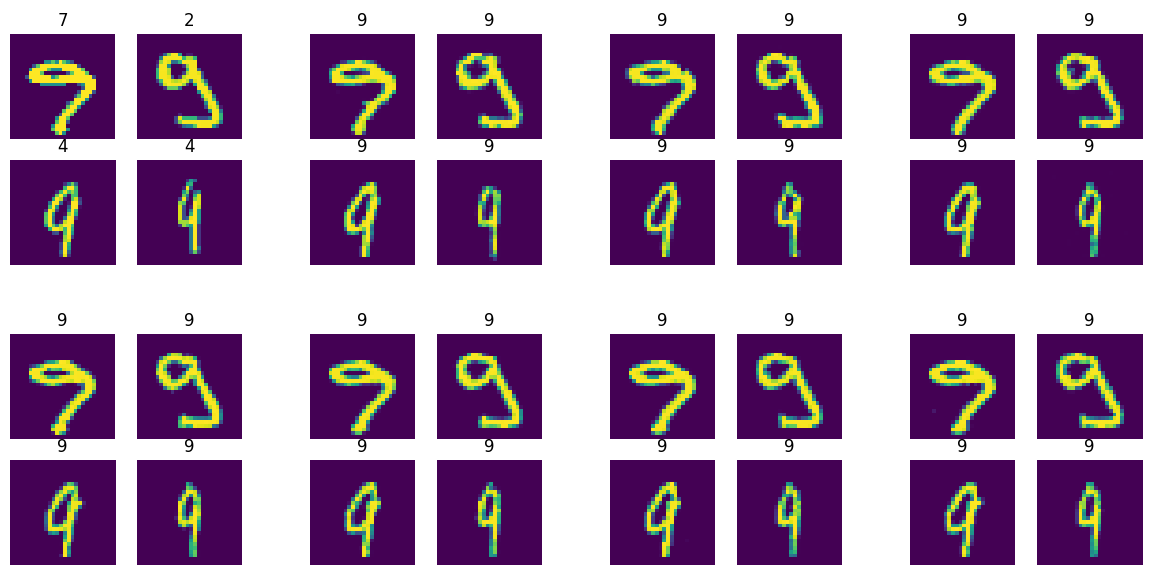

In [66]:
torch.manual_seed(0)

size = 3 # img side size
n_samples = 1 # 16 # num img
num_intermidiate_steps = 8
show_preds = True
n_rows = 2

version = 'test'

defualt_hyper_params = dict(
    tau = 8, #25
    lambda_p = 0,
    lambda_c = 20,
    vgg_block = 2,
    n_reconstruct_samples = 1
)

show_steps = np.linspace(0, defualt_hyper_params['tau'], num_intermidiate_steps, endpoint=True, dtype=int)

assert max(show_steps) <= defualt_hyper_params['tau'], f"Cannot show step {max(show_steps)} when {defualt_hyper_params['tau']=}"

n_steps = len(show_steps)
multiplot_side = math.sqrt(n_samples)

fig = plt.figure(figsize=(multiplot_side*size*n_steps/n_rows, multiplot_side*size*n_rows))
fig.suptitle('Intermidiate steps', size=16)
subfigs = fig.subfigures(n_rows, math.ceil(n_steps/n_rows))

x_counterfact, intermediate_reconstructs = diffusion.guided_counterfactual(
        unet_model,
        classifier,
        misclassified_batch,
        label,
        return_intermediate=True,
        **defualt_hyper_params
)
intermediate_reconstructs = intermediate_reconstructs.clamp(0, 1)

for figure, step in zip(subfigs.flatten(), show_steps):
    # figure.suptitle(f'step {step}', size=16)
    x_reconstruct = intermediate_reconstructs[step]
    y_pred = classifier.predict(x_reconstruct) if show_preds else None
    show_out_images(x_reconstruct, y=y_pred, fig=figure)

plt.savefig(plot_path + 'counterfact_intermidiate_misclassified', bbox_inches='tight')
plt.show()

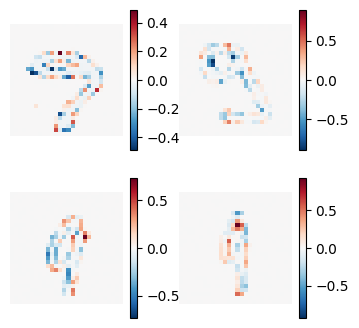

In [67]:
diff = x_counterfact - misclassified_batch
fig = show_out_images(diff, ax_kwargs={'cmap': 'RdBu_r'})
for i in range(len(fig.axes)):
    min_val = fig.axes[i].images[0].get_array().min()
    max_val = fig.axes[i].images[0].get_array().max()
    max_abs = max(abs(min_val), abs(max_val))
    fig.axes[i].images[0].set_clim(-max_abs, max_abs)
    plt.colorbar(fig.axes[i].images[0])

plt.savefig(plot_path + 'counterfact_misclassified_diffplot', bbox_inches='tight')
plt.show()